In [288]:
from bs4 import BeautifulSoup
import requests

import warnings
warnings.filterwarnings("ignore")

import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id="a2e7f74adf174c539ff89ee669b9a991",
                                                           client_secret="8672060b923c481cbbbb13bb01bccab2"))


import pandas as pd
import numpy as np

import time
from time import sleep

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AffinityPropagation
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.metrics import silhouette_score
from sklearn.metrics import classification_report
from scipy.spatial import distance_matrix

import matplotlib.pyplot as plt 
from yellowbrick.cluster import SilhouetteVisualizer
from yellowbrick.cluster import KElbowVisualizer


### Getting the top 100

In [611]:
song_name = []
artist = []

r = requests.get('http://www.popvortex.com/music/charts/top-100-songs.php')
r.status_code

200

In [612]:
html = r.content

soup = BeautifulSoup(html, 'html.parser')

pretty_soup = soup.prettify()
print(pretty_soup)

<!DOCTYPE html>
<html lang="en">
 <head>
  <meta charset="utf-8"/>
  <title>
   iTunes Top 100 Songs Chart 2022
  </title>
  <meta content="width=device-width, initial-scale=1" name="viewport"/>
  <meta content="iTunes top 100 songs chart list. The most popular hit music and trending songs of 2022. Chart of today's current iTunes top 100 songs is updated daily." name="description"/>
  <meta content="iTunes Top 100 Songs Chart 2022" property="og:title">
   <meta content="Chart of the top 100 songs on iTunes. Chart list of the top 100 song downloads of 2022 is updated daily." property="og:description">
    <meta content="article" property="og:type">
     <meta content="http://www.popvortex.com/images/logo-facebook.png" property="og:image"/>
     <meta content="PopVortex" property="og:site_name"/>
     <meta content="http://www.popvortex.com/music/charts/top-100-songs.php" property="og:url"/>
     <meta content="100000239962942" property="fb:admins"/>
     <meta content="178831188827052" 

###### 1st song and 1st artist

In [613]:
print(soup.select("cite.title")[0].get_text())
print(soup.select("em.artist")[0].get_text())

Running Up That Hill (A Deal with God)
Kate Bush


#### Creating the top 100 dataframe

In [614]:
# Creating two lists for the artists and songs
num_iter = len(soup.select("cite.title"))
num_iter_2 = len(soup.select("em.artist"))

for i in range(num_iter):
    song_name.append(soup.select("cite.title")[i].get_text())
    
for i in range(num_iter_2):
    artist.append(soup.select("em.artist")[i].get_text())
    
# each list becomes a column
billboard = pd.DataFrame({"song":song_name,
                       "artist":artist,
                      })

billboard.head()

,song,artist
0,Running Up That Hill (A Deal with God),Kate Bush
1,Yet To Come,BTS
2,Rock and A Hard Place,Bailey Zimmerman
3,Hold My Hand,Lady Gaga
4,As It Was,Harry Styles


In [466]:
billboard['song_artist'] = billboard['song'] + ' - ' + billboard['artist']
billboard.head()

,song,artist,song_artist
0,Running Up That Hill (A Deal with God),Kate Bush,Running Up That Hill (A Deal with God) - Kate ...
1,Yet To Come,BTS,Yet To Come - BTS
2,Rock and A Hard Place,Bailey Zimmerman,Rock and A Hard Place - Bailey Zimmerman
3,Run BTS,BTS,Run BTS - BTS
4,Hold My Hand,Lady Gaga,Hold My Hand - Lady Gaga


### Getting a pool of 2000+ songs for the recommendations

#### Playlists repertoire

In [14]:
# Creating a dictionary with the selected playlists

playlists = {}

# Pop
playlists['soft_pop_hits'] = '37i9dQZF1DWTwnEm1IYyoj'
playlists['party_hits'] = '37i9dQZF1DXa2PvUpywmrr'
playlists['hot_hit_uk'] = '37i9dQZF1DWY4lFlS4Pnso'

# Indie & Alt
playlists['indie_folk_2022'] = '1Qs40FRP061tVZ9x2npAE3'
playlists['chill+atmospheric'] = '37i9dQZF1DX79Y9Kr2M2tM'
playlists['a_bit_of_mumford_a_dash_of_sons'] = '6PjEbhssYWCdfAyDnRqBQN'
playlists['indie_road_trip'] = '37i9dQZF1DWSQScAbo5nGF'
playlists['you_&_me'] = '37i9dQZF1DX6mvEU1S6INL'
playlists['alternative_00s'] = '37i9dQZF1DX0YKekzl0blG'
playlists['alternative_10s'] = '37i9dQZF1DX873GaRGUmPl'
playlists['alternative_80s'] = '37i9dQZF1DWTSKFpOdYF1r'

# Rock
playlists['70s_rock_anthems'] = '37i9dQZF1DWWwzidNQX6jx'
playlists['80s_rock_anthems'] = '37i9dQZF1DX1spT6G94GFC'
playlists['soft_rock'] = '37i9dQZF1DX6xOPeSOGone'
playlists['rock_party'] = '37i9dQZF1DX8FwnYE6PRvL'


# Dance, Electro, Techno, House
playlists['throwback_party'] = '37i9dQZF1DX7F6T2n2fegs'
playlists['best_of_house_2000_2010'] = '4feq7UBWFnq7ACWqILr3D5'

# Rap
playlists['rap_caviar'] = '37i9dQZF1DX0XUsuxWHRQd'
playlists['i_love_my_90s_hiphop'] = '37i9dQZF1DX186v583rmzp'
playlists['most_necessary'] = '37i9dQZF1DX2RxBh64BHjQ'

# R&B
playlists['are_be'] = '37i9dQZF1DX4SBhb3fqCJd'
playlists['i_love_my_90s_rb'] = '37i9dQZF1DX6VDO8a6cQME'

# Jazz & Blues
playlists['coffee_table_jazz'] = '37i9dQZF1DWVqfgj8NZEp1'
playlists['blues_classics'] = '37i9dQZF1DXd9rSDyQguIk'

# Country
playlists['hot_country'] = '37i9dQZF1DX1lVhptIYRda'

# Classical
playlists['classical_essentials'] = '37i9dQZF1DWWEJlAGA9gs0'

# Latin
playlists['viva_latino'] = '37i9dQZF1DX10zKzsJ2jva'

# Other
playlists['witchy_woman'] = '5HNKy8FV7atlGgklq5VcpE'
playlists['video_game_soundtracks'] = '37i9dQZF1DXdfOcg1fm0VG'

#### Useful functions

In [18]:
# function to get the tracks of a playlist
def get_playlist_tracks(username, playlist_id):
    
    results = sp.user_playlist_tracks(username, playlist_id)
    tracks = results['items']
    
    while results['next']:
        results = sp.next(results)
        tracks.extend(results['items'])
    
    return tracks


# function to get the features we need
def get_2000(playlists):
    
    track_ids = []
    track_names = []
    track_pops = []
    artist_names = []
    artist_pops = []
    artist_genres = []
    
    for playlist in playlists.values():
        tracks_from_playlist = get_playlist_tracks("spotify", playlist)

        for track in tracks_from_playlist:
            
            #URI
            track_ids.append(track["track"]["id"])
    
            #Track name
            track_names.append(track["track"]["name"])

            #Main Artist
            artist_uri = track["track"]["artists"][0]["uri"]
            artist_info = sp.artist(artist_uri)

            #Name, popularity, genre
            artist_names.append(track["track"]["artists"][0]["name"])
            artist_pops.append(artist_info["popularity"])
            artist_genres.append(artist_info["genres"])

            #Popularity of the track
            track_pops.append(track["track"]["popularity"])

    artists_df = pd.DataFrame(list(zip(track_ids, track_names, track_pops, artist_names, artist_pops, artist_genres)), 
                              columns =['track_id', 'track_name', 'track_popularity', 'artist_name', 'artist_popularity', 
                                        'genres'])
    
    return artists_df

#### Creating song pool dataframe

In [19]:
songs_2000 = get_2000(playlists)
print(songs_2000.shape[0])
songs_2000.head()

2707


,track_id,track_name,track_popularity,artist_name,artist_popularity,genres
0,0gplL1WMoJ6iYaPgMCL0gX,Easy On Me,87,Adele,84,"[british soul, pop, pop soul, uk pop]"
1,6I3mqTwhRpn34SLVafSH7G,Ghost,89,Justin Bieber,90,"[canadian pop, pop]"
2,0lx2cLdOt3piJbcaXIV74f,willow,77,Taylor Swift,92,[pop]
3,0oWraSo5ASJ0h1BEagTyEw,Hold My Hand,82,Lady Gaga,83,"[art pop, dance pop, pop]"
4,78nplE9X2ZGvQh3TKgvldE,Rewrite The Stars (with James Arthur & Anne-Ma...,66,James Arthur,77,"[pop, talent show, uk pop]"


##### Checking the number of unique values

In [20]:
len(songs_2000.track_id.unique())

2632

###### Dropping the duplicates and keeping the first instance - we are not interested in having the same song more than once

In [21]:
songs_2000 = songs_2000.drop_duplicates(keep="first", subset=['track_id'])
print(len(songs_2000.track_id.unique()))
songs_2000.head()

2632


,track_id,track_name,track_popularity,artist_name,artist_popularity,genres
0,0gplL1WMoJ6iYaPgMCL0gX,Easy On Me,87,Adele,84,"[british soul, pop, pop soul, uk pop]"
1,6I3mqTwhRpn34SLVafSH7G,Ghost,89,Justin Bieber,90,"[canadian pop, pop]"
2,0lx2cLdOt3piJbcaXIV74f,willow,77,Taylor Swift,92,[pop]
3,0oWraSo5ASJ0h1BEagTyEw,Hold My Hand,82,Lady Gaga,83,"[art pop, dance pop, pop]"
4,78nplE9X2ZGvQh3TKgvldE,Rewrite The Stars (with James Arthur & Anne-Ma...,66,James Arthur,77,"[pop, talent show, uk pop]"


### Retrieving the audio features

In [22]:
# Getting the audio features with the track_ids
audio = []

track_ids = list(songs_2000.track_id)

for track_id in track_ids:
    features = sp.audio_features(track_id)
    sleep(0.005)
    audio.append(features)
    
audio

[[{'danceability': 0.604,
   'energy': 0.366,
   'key': 5,
   'loudness': -7.519,
   'mode': 1,
   'speechiness': 0.0282,
   'acousticness': 0.578,
   'instrumentalness': 0,
   'liveness': 0.133,
   'valence': 0.13,
   'tempo': 141.981,
   'type': 'audio_features',
   'id': '0gplL1WMoJ6iYaPgMCL0gX',
   'uri': 'spotify:track:0gplL1WMoJ6iYaPgMCL0gX',
   'track_href': 'https://api.spotify.com/v1/tracks/0gplL1WMoJ6iYaPgMCL0gX',
   'analysis_url': 'https://api.spotify.com/v1/audio-analysis/0gplL1WMoJ6iYaPgMCL0gX',
   'duration_ms': 224695,
   'time_signature': 4}],
 [{'danceability': 0.601,
   'energy': 0.741,
   'key': 2,
   'loudness': -5.569,
   'mode': 1,
   'speechiness': 0.0478,
   'acousticness': 0.185,
   'instrumentalness': 2.91e-05,
   'liveness': 0.415,
   'valence': 0.441,
   'tempo': 153.96,
   'type': 'audio_features',
   'id': '6I3mqTwhRpn34SLVafSH7G',
   'uri': 'spotify:track:6I3mqTwhRpn34SLVafSH7G',
   'track_href': 'https://api.spotify.com/v1/tracks/6I3mqTwhRpn34SLVafSH7G'

In [23]:
# Creating a dataframe of audio features
audio_features = pd.DataFrame()

for i in range(0, len(songs_2000.track_id)):
    aud = pd.DataFrame(audio[i])
    audio_features = pd.concat([audio_features, aud])
    
audio_features

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,0.604,0.3660,5,-7.519,1,0.0282,0.5780,0.000000,0.1330,0.1300,141.981,audio_features,0gplL1WMoJ6iYaPgMCL0gX,spotify:track:0gplL1WMoJ6iYaPgMCL0gX,https://api.spotify.com/v1/tracks/0gplL1WMoJ6i...,https://api.spotify.com/v1/audio-analysis/0gpl...,224695,4
0,0.601,0.7410,2,-5.569,1,0.0478,0.1850,0.000029,0.4150,0.4410,153.960,audio_features,6I3mqTwhRpn34SLVafSH7G,spotify:track:6I3mqTwhRpn34SLVafSH7G,https://api.spotify.com/v1/tracks/6I3mqTwhRpn3...,https://api.spotify.com/v1/audio-analysis/6I3m...,153190,4
0,0.392,0.5740,7,-9.195,1,0.1700,0.8330,0.001790,0.1450,0.5290,81.112,audio_features,0lx2cLdOt3piJbcaXIV74f,spotify:track:0lx2cLdOt3piJbcaXIV74f,https://api.spotify.com/v1/tracks/0lx2cLdOt3pi...,https://api.spotify.com/v1/audio-analysis/0lx2...,214707,4
0,0.519,0.6170,7,-4.287,1,0.0313,0.0387,0.000000,0.4010,0.2220,147.708,audio_features,0oWraSo5ASJ0h1BEagTyEw,spotify:track:0oWraSo5ASJ0h1BEagTyEw,https://api.spotify.com/v1/tracks/0oWraSo5ASJ0...,https://api.spotify.com/v1/audio-analysis/0oWr...,225300,3
0,0.670,0.7430,10,-4.993,1,0.0393,0.2370,0.000000,0.4650,0.5710,125.944,audio_features,78nplE9X2ZGvQh3TKgvldE,spotify:track:78nplE9X2ZGvQh3TKgvldE,https://api.spotify.com/v1/tracks/78nplE9X2ZGv...,https://api.spotify.com/v1/audio-analysis/78np...,218293,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,0.212,0.1480,0,-16.090,1,0.0451,0.9490,0.903000,0.0915,0.0375,72.170,audio_features,1ObRVltzyUfuBbJsxGvCRs,spotify:track:1ObRVltzyUfuBbJsxGvCRs,https://api.spotify.com/v1/tracks/1ObRVltzyUfu...,https://api.spotify.com/v1/audio-analysis/1ObR...,103893,5
0,0.440,0.5860,9,-7.756,0,0.0333,0.8190,0.934000,0.0807,0.2230,156.008,audio_features,6yt8SuNkqup43idePXmKt2,spotify:track:6yt8SuNkqup43idePXmKt2,https://api.spotify.com/v1/tracks/6yt8SuNkqup4...,https://api.spotify.com/v1/audio-analysis/6yt8...,255493,5
0,0.188,0.2400,0,-22.317,1,0.0655,0.8630,0.853000,0.1930,0.0748,82.598,audio_features,3XjWFz19CqI8IP1h5JdSdH,spotify:track:3XjWFz19CqI8IP1h5JdSdH,https://api.spotify.com/v1/tracks/3XjWFz19CqI8...,https://api.spotify.com/v1/audio-analysis/3XjW...,189910,4
0,0.160,0.0622,8,-23.948,1,0.0359,0.9440,0.925000,0.0769,0.0392,144.650,audio_features,7xiqFMenX3KY3kINA88d8Q,spotify:track:7xiqFMenX3KY3kINA88d8Q,https://api.spotify.com/v1/tracks/7xiqFMenX3KY...,https://api.spotify.com/v1/audio-analysis/7xiq...,255688,3


In [565]:
# Discarding the unnecessary columns (links)
audio_features = audio_features[['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 
                                 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature']]

audio_features

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,0.604,0.3660,5,-7.519,1,0.0282,0.5780,0.000000,0.1330,0.1300,141.981,224695,4
1,0.601,0.7410,2,-5.569,1,0.0478,0.1850,0.000029,0.4150,0.4410,153.960,153190,4
2,0.392,0.5740,7,-9.195,1,0.1700,0.8330,0.001790,0.1450,0.5290,81.112,214707,4
3,0.519,0.6170,7,-4.287,1,0.0313,0.0387,0.000000,0.4010,0.2220,147.708,225300,3
4,0.670,0.7430,10,-4.993,1,0.0393,0.2370,0.000000,0.4650,0.5710,125.944,218293,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2627,0.212,0.1480,0,-16.090,1,0.0451,0.9490,0.903000,0.0915,0.0375,72.170,103893,5
2628,0.440,0.5860,9,-7.756,0,0.0333,0.8190,0.934000,0.0807,0.2230,156.008,255493,5
2629,0.188,0.2400,0,-22.317,1,0.0655,0.8630,0.853000,0.1930,0.0748,82.598,189910,4
2630,0.160,0.0622,8,-23.948,1,0.0359,0.9440,0.925000,0.0769,0.0392,144.650,255688,3


In [25]:
# creating the master dataframe
songs_2000.reset_index(drop=True, inplace=True)
audio_features.reset_index(drop=True, inplace=True)
song_pool = pd.concat([songs_2000, audio_features], axis=1)
song_pool

,track_id,track_name,track_popularity,artist_name,artist_popularity,genres,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,0gplL1WMoJ6iYaPgMCL0gX,Easy On Me,87,Adele,84,"[british soul, pop, pop soul, uk pop]",0.604,0.3660,5,-7.519,1,0.0282,0.5780,0.000000,0.1330,0.1300,141.981,224695,4
1,6I3mqTwhRpn34SLVafSH7G,Ghost,89,Justin Bieber,90,"[canadian pop, pop]",0.601,0.7410,2,-5.569,1,0.0478,0.1850,0.000029,0.4150,0.4410,153.960,153190,4
2,0lx2cLdOt3piJbcaXIV74f,willow,77,Taylor Swift,92,[pop],0.392,0.5740,7,-9.195,1,0.1700,0.8330,0.001790,0.1450,0.5290,81.112,214707,4
3,0oWraSo5ASJ0h1BEagTyEw,Hold My Hand,82,Lady Gaga,83,"[art pop, dance pop, pop]",0.519,0.6170,7,-4.287,1,0.0313,0.0387,0.000000,0.4010,0.2220,147.708,225300,3
4,78nplE9X2ZGvQh3TKgvldE,Rewrite The Stars (with James Arthur & Anne-Ma...,66,James Arthur,77,"[pop, talent show, uk pop]",0.670,0.7430,10,-4.993,1,0.0393,0.2370,0.000000,0.4650,0.5710,125.944,218293,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2627,1ObRVltzyUfuBbJsxGvCRs,All the Earth,44,Jessica Curry,41,"[indie game soundtrack, orchestral soundtrack,...",0.212,0.1480,0,-16.090,1,0.0451,0.9490,0.903000,0.0915,0.0375,72.170,103893,5
2628,6yt8SuNkqup43idePXmKt2,Saber's Edge (Final Fantasy XIII),35,Masashi Hamauzu,31,[final fantasy],0.440,0.5860,9,-7.756,0,0.0333,0.8190,0.934000,0.0807,0.2230,156.008,255493,5
2629,3XjWFz19CqI8IP1h5JdSdH,Prelude and Main Titles,30,Never Alone,13,[],0.188,0.2400,0,-22.317,1,0.0655,0.8630,0.853000,0.1930,0.0748,82.598,189910,4
2630,7xiqFMenX3KY3kINA88d8Q,Title Theme,42,Russell Shaw,33,[video game music],0.160,0.0622,8,-23.948,1,0.0359,0.9440,0.925000,0.0769,0.0392,144.650,255688,3


#### Looking at the unique genres

In [39]:
song_pool.genres.unique

<bound method Series.unique of 0                   [british soul, pop, pop soul, uk pop]
1                                     [canadian pop, pop]
2                                                   [pop]
3                               [art pop, dance pop, pop]
4                              [pop, talent show, uk pop]
                              ...                        
2627    [indie game soundtrack, orchestral soundtrack,...
2628                                      [final fantasy]
2629                                                   []
2630                                   [video game music]
2631                                   [video game music]
Name: genres, Length: 2632, dtype: object>

There are too many unique values to encode, and songs can have multiple genres, some of them being more relevant and important than others.

In [289]:
# TF-IDF implementation
tfidf = TfidfVectorizer()
tfidf_matrix =  tfidf.fit_transform(song_pool['genres'].apply(lambda x: " ".join(x)))
genre_df = pd.DataFrame(tfidf_matrix.toarray())
genre_df.columns = ['genre' + "|" + i for i in tfidf.get_feature_names()]
#genre_df.drop(columns='genre|unknown') # Drop unknown genre
genre_df.reset_index(drop = True, inplace=True)
genre_df.iloc[0]

genre|aarhus       0.0
genre|acid         0.0
genre|acoustic     0.0
genre|adult        0.0
genre|aesthetic    0.0
                  ... 
genre|wu           0.0
genre|yacht        0.0
genre|york         0.0
genre|yorkshire    0.0
genre|zolo         0.0
Name: 0, Length: 565, dtype: float64

In [40]:
X_pop = song_pool[['track_popularity', 'artist_popularity', 'danceability', 'energy', 'key',
       'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature']]

## Preparing the data for modeling

In [651]:
# I will use this function to scale the data with StandardScaler
def standard_scaling(df):
    transformer = StandardScaler().fit(df)
    x_standardized = transformer.transform(df)
    X = pd.DataFrame(x_standardized)
    X.columns = df.columns
    return X

#### Data without the popularity features and without the genre

In [566]:
X_scaled = standard_scaling(audio_features)
X_scaled.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,0.176950,-0.796987,-0.036867,0.343421,0.748442,-0.573629,0.718529,-0.563929,-0.261150,-1.289311,0.822049,-0.246834,0.234849
1,0.160580,0.641515,-0.878208,0.688843,0.748442,-0.339503,-0.401183,-0.563838,1.913108,-0.113390,1.250197,-0.954782,0.234849
2,-0.979837,0.000902,0.524027,0.046536,0.748442,1.120199,1.445060,-0.558320,-0.168628,0.219346,-1.353505,-0.345722,0.234849
3,-0.286856,0.165850,0.524027,0.915935,0.748442,-0.536599,-0.818013,-0.563929,1.805166,-0.941450,1.026741,-0.240844,-2.406704
4,0.537082,0.649187,1.365367,0.790875,0.748442,-0.441038,-0.253028,-0.563929,2.298615,0.378152,0.248861,-0.310218,0.234849


#### Data with the genre features

In [511]:
genre_df.index = audio_features.index

X = pd.concat([audio_features, genre_df], axis=1)

X_prep = standard_scaling(X)
X_prep.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,...,genre|women,genre|woogie,genre|world,genre|worship,genre|worth,genre|wu,genre|yacht,genre|york,genre|yorkshire,genre|zolo
0,0.176950,-0.796987,-0.036867,0.343421,0.748442,-0.573629,0.718529,-0.563929,-0.261150,-1.289311,...,-0.038905,-0.035273,-0.019496,-0.019496,-0.019496,-0.019496,-0.122123,-0.038988,-0.019496,-0.043429
1,0.160580,0.641515,-0.878208,0.688843,0.748442,-0.339503,-0.401183,-0.563838,1.913108,-0.113390,...,-0.038905,-0.035273,-0.019496,-0.019496,-0.019496,-0.019496,-0.122123,-0.038988,-0.019496,-0.043429
2,-0.979837,0.000902,0.524027,0.046536,0.748442,1.120199,1.445060,-0.558320,-0.168628,0.219346,...,-0.038905,-0.035273,-0.019496,-0.019496,-0.019496,-0.019496,-0.122123,-0.038988,-0.019496,-0.043429
3,-0.286856,0.165850,0.524027,0.915935,0.748442,-0.536599,-0.818013,-0.563929,1.805166,-0.941450,...,-0.038905,-0.035273,-0.019496,-0.019496,-0.019496,-0.019496,-0.122123,-0.038988,-0.019496,-0.043429
4,0.537082,0.649187,1.365367,0.790875,0.748442,-0.441038,-0.253028,-0.563929,2.298615,0.378152,...,-0.038905,-0.035273,-0.019496,-0.019496,-0.019496,-0.019496,-0.122123,-0.038988,-0.019496,-0.043429


## Building a Clustering Model

### KMeans

In [578]:
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(X_scaled)

KMeans(n_clusters=4, random_state=42)

In [568]:
X_scaled

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,0.176950,-0.796987,-0.036867,0.343421,0.748442,-0.573629,0.718529,-0.563929,-0.261150,-1.289311,0.822049,-0.246834,0.234849
1,0.160580,0.641515,-0.878208,0.688843,0.748442,-0.339503,-0.401183,-0.563838,1.913108,-0.113390,1.250197,-0.954782,0.234849
2,-0.979837,0.000902,0.524027,0.046536,0.748442,1.120199,1.445060,-0.558320,-0.168628,0.219346,-1.353505,-0.345722,0.234849
3,-0.286856,0.165850,0.524027,0.915935,0.748442,-0.536599,-0.818013,-0.563929,1.805166,-0.941450,1.026741,-0.240844,-2.406704
4,0.537082,0.649187,1.365367,0.790875,0.748442,-0.441038,-0.253028,-0.563929,2.298615,0.378152,0.248861,-0.310218,0.234849
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2627,-1.962014,-1.633236,-1.439102,-1.174839,0.748442,-0.371755,1.775560,2.265796,-0.581121,-1.639062,-1.673106,-1.442856,2.876403
2628,-0.717923,0.046934,1.084920,0.301439,-1.336108,-0.512709,1.405172,2.362941,-0.664390,-0.937669,1.323396,0.058088,2.876403
2629,-2.092971,-1.280323,-1.439102,-2.277886,0.748442,-0.128074,1.530534,2.109111,0.201458,-1.498027,-1.300393,-0.591229,0.234849
2630,-2.245754,-1.962365,0.804473,-2.566800,0.748442,-0.481651,1.761314,2.334737,-0.693689,-1.632634,0.917443,0.060018,-2.406704


In [513]:
# Predicting / assigning the clusters:
clusters = kmeans.predict(X_scaled)
clusters

array([2, 3, 2, ..., 0, 0, 0])

### Analyzing the results

In [514]:
# Check the size of the clusters
pd.Series(clusters).value_counts().sort_index()

0    349
1    568
2    522
3    942
4    251
dtype: int64

In [515]:
# "performance metric" --> difficult to understand because it is not normalized
kmeans.inertia_

20736.442564988858

In [516]:
# Explore the cluster assignment in the original dataset
results_df = pd.DataFrame(song_pool)
results_df["cluster"] = clusters
results_df.head()

,track_id,track_name,track_popularity,artist_name,artist_popularity,genres,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,cluster
0,0gplL1WMoJ6iYaPgMCL0gX,Easy On Me,87,Adele,84,"[british soul, pop, pop soul, uk pop]",0.604,0.366,5,-7.519,1,0.0282,0.5780,0.000000,0.133,0.130,141.981,224695,4,2
1,6I3mqTwhRpn34SLVafSH7G,Ghost,89,Justin Bieber,90,"[canadian pop, pop]",0.601,0.741,2,-5.569,1,0.0478,0.1850,0.000029,0.415,0.441,153.960,153190,4,3
2,0lx2cLdOt3piJbcaXIV74f,willow,77,Taylor Swift,92,[pop],0.392,0.574,7,-9.195,1,0.1700,0.8330,0.001790,0.145,0.529,81.112,214707,4,2
3,0oWraSo5ASJ0h1BEagTyEw,Hold My Hand,82,Lady Gaga,83,"[art pop, dance pop, pop]",0.519,0.617,7,-4.287,1,0.0313,0.0387,0.000000,0.401,0.222,147.708,225300,3,3
4,78nplE9X2ZGvQh3TKgvldE,Rewrite The Stars (with James Arthur & Anne-Ma...,66,James Arthur,77,"[pop, talent show, uk pop]",0.670,0.743,10,-4.993,1,0.0393,0.2370,0.000000,0.465,0.571,125.944,218293,4,3


## Choosing the best K

### Inertia

[28394.12621348605, 25426.931897128718, 22542.204328175914, 20736.442564988858, 19759.343446335704, 18854.39491429235, 18107.661589256324, 17426.02240378906, 16853.065823558263, 16330.707688540857, 15980.324283496891, 15578.697488660171, 15134.503304514345, 15065.40449800373, 14715.607934644595, 14437.699770183157, 14163.562851655146, 13791.351662654282]


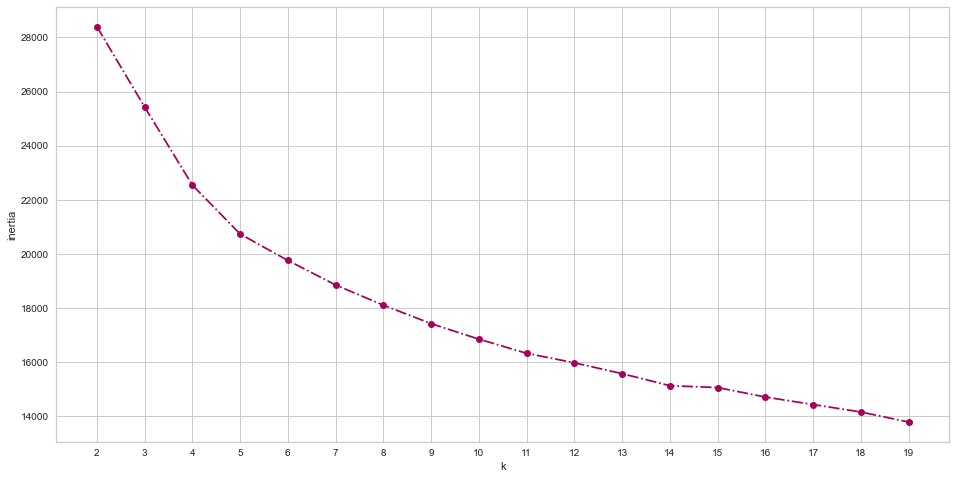

In [517]:
K = range(2, 20)

inertia = []

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=1234)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

print(inertia)

plt.figure(figsize=(16,8))
plt.plot(K, inertia, 'o-.m')
plt.xlabel('k')
plt.ylabel('inertia')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.show()

### Visualizing the elbow with Yellowbrick

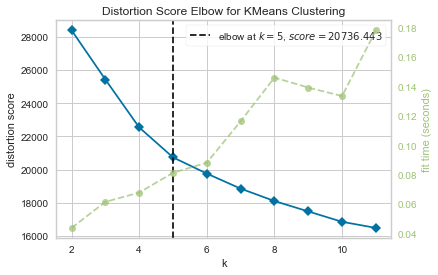

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [518]:
visualizer = KElbowVisualizer(km, k=(2,12))

visualizer.fit(X_scaled)    # Fit the data to the visualizer
visualizer.poof() 

### Silhouette

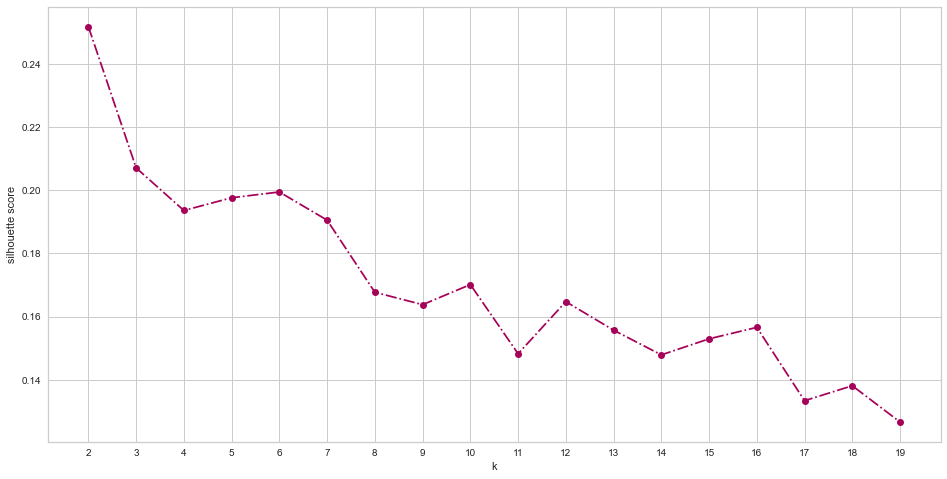

In [519]:
K = range(2, 20)

silhouette = []

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    silhouette.append(silhouette_score(X_scaled, kmeans.predict(X_scaled)))


plt.figure(figsize=(16,8))
plt.plot(K, silhouette, 'o-.m')
plt.xlabel('k')
plt.ylabel('silhouette score')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.show()

###### Potential elbows: 3, 4, 6, 8

### Silhouette Visualizer

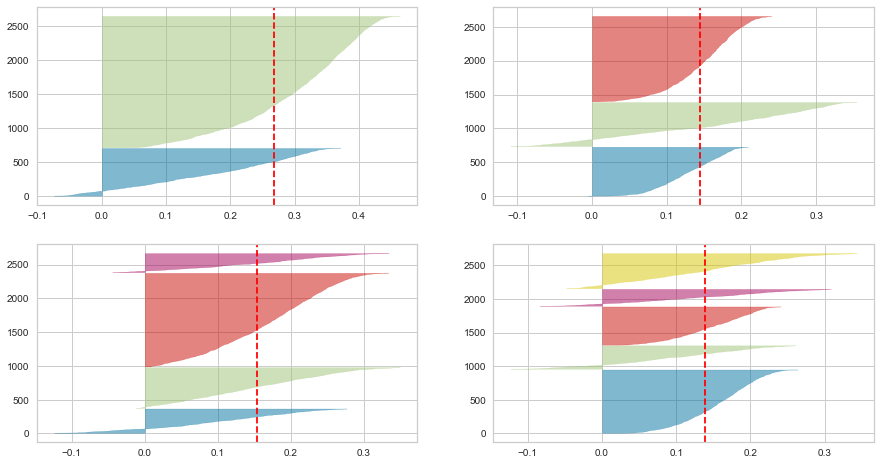

In [725]:
fig, ax = plt.subplots(2, 2, figsize=(15,8))
for i in [2, 3, 4, 5]:
    '''
    Create KMeans instance for different number of clusters
    '''
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(i, 2)
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(X_scaled)

## Visualizing the results

In [529]:
## Transform the data into 2D so we can see
pca = PCA(2) 
X_2D = pca.fit_transform(X_scaled)
X_2D

array([[ 0.85673786,  0.8793546 ],
       [-1.57113572, -1.35155385],
       [ 0.75363424,  1.59625004],
       ...,
       [ 4.04099512, -0.84461284],
       [ 5.08555735, -1.22459707],
       [ 3.21632608, -0.85950215]])

### k = 2

In [559]:
kmeans_2 = KMeans(n_clusters=2, random_state=42)
kmeans_2.fit(X_2D)
clusters_2 = kmeans_2.predict(X_2D)

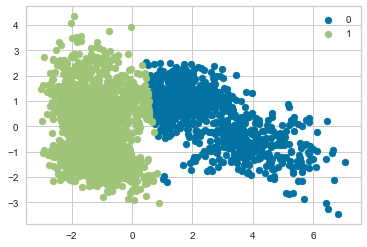

In [560]:
labels = np.unique(clusters_2)

for i in labels:
    plt.scatter(X_2D[clusters_2 == i , 0] , X_2D[clusters_2 == i , 1] , label = i)
plt.legend()
plt.show()

In [532]:
# Explore the cluster assignment in the original dataset
results_k2 = pd.DataFrame(song_pool)
results_k2["cluster"] = clusters_2
results_k2.head()

,track_id,track_name,track_popularity,artist_name,artist_popularity,genres,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,cluster
0,0gplL1WMoJ6iYaPgMCL0gX,Easy On Me,87,Adele,84,"[british soul, pop, pop soul, uk pop]",0.604,0.366,5,-7.519,1,0.0282,0.5780,0.000000,0.133,0.130,141.981,224695,4,0
1,6I3mqTwhRpn34SLVafSH7G,Ghost,89,Justin Bieber,90,"[canadian pop, pop]",0.601,0.741,2,-5.569,1,0.0478,0.1850,0.000029,0.415,0.441,153.960,153190,4,1
2,0lx2cLdOt3piJbcaXIV74f,willow,77,Taylor Swift,92,[pop],0.392,0.574,7,-9.195,1,0.1700,0.8330,0.001790,0.145,0.529,81.112,214707,4,0
3,0oWraSo5ASJ0h1BEagTyEw,Hold My Hand,82,Lady Gaga,83,"[art pop, dance pop, pop]",0.519,0.617,7,-4.287,1,0.0313,0.0387,0.000000,0.401,0.222,147.708,225300,3,1
4,78nplE9X2ZGvQh3TKgvldE,Rewrite The Stars (with James Arthur & Anne-Ma...,66,James Arthur,77,"[pop, talent show, uk pop]",0.670,0.743,10,-4.993,1,0.0393,0.2370,0.000000,0.465,0.571,125.944,218293,4,1


### k = 4

In [555]:
kmeans_4 = KMeans(n_clusters=4, random_state=42)
kmeans_4.fit(X_2D)
clusters_4 = kmeans_4.predict(X_2D)

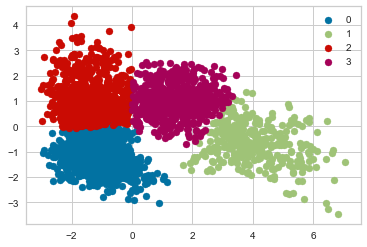

In [535]:
labels = np.unique(clusters_4)

for i in labels:
    plt.scatter(X_2D[clusters_4 == i , 0] , X_2D[clusters_4 == i , 1] , label = i)
plt.legend()
plt.show()

In [536]:
# Explore the cluster assignment in the original dataset
results_k4 = pd.DataFrame(song_pool)
results_k4["cluster"] = clusters_4
results_k4.head()

,track_id,track_name,track_popularity,artist_name,artist_popularity,genres,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,cluster
0,0gplL1WMoJ6iYaPgMCL0gX,Easy On Me,87,Adele,84,"[british soul, pop, pop soul, uk pop]",0.604,0.366,5,-7.519,1,0.0282,0.5780,0.000000,0.133,0.130,141.981,224695,4,3
1,6I3mqTwhRpn34SLVafSH7G,Ghost,89,Justin Bieber,90,"[canadian pop, pop]",0.601,0.741,2,-5.569,1,0.0478,0.1850,0.000029,0.415,0.441,153.960,153190,4,0
2,0lx2cLdOt3piJbcaXIV74f,willow,77,Taylor Swift,92,[pop],0.392,0.574,7,-9.195,1,0.1700,0.8330,0.001790,0.145,0.529,81.112,214707,4,3
3,0oWraSo5ASJ0h1BEagTyEw,Hold My Hand,82,Lady Gaga,83,"[art pop, dance pop, pop]",0.519,0.617,7,-4.287,1,0.0313,0.0387,0.000000,0.401,0.222,147.708,225300,3,0
4,78nplE9X2ZGvQh3TKgvldE,Rewrite The Stars (with James Arthur & Anne-Ma...,66,James Arthur,77,"[pop, talent show, uk pop]",0.670,0.743,10,-4.993,1,0.0393,0.2370,0.000000,0.465,0.571,125.944,218293,4,0


### k = 5

In [557]:
kmeans_5 = KMeans(n_clusters=5, random_state=42)
kmeans_5.fit(X_2D)
clusters_5 = kmeans_5.predict(X_2D)

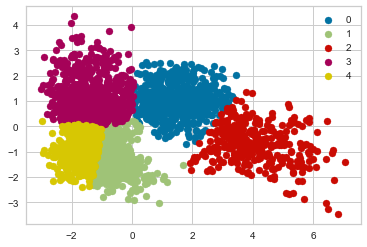

In [538]:
labels = np.unique(clusters_5)

for i in labels:
    plt.scatter(X_2D[clusters_5 == i , 0] , X_2D[clusters_5 == i , 1] , label = i)
plt.legend()
plt.show()

In [539]:
# Explore the cluster assignment in the original dataset
results_k5 = pd.DataFrame(song_pool)
results_k5["cluster"] = clusters_5
results_k5.head()

,track_id,track_name,track_popularity,artist_name,artist_popularity,genres,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,cluster
0,0gplL1WMoJ6iYaPgMCL0gX,Easy On Me,87,Adele,84,"[british soul, pop, pop soul, uk pop]",0.604,0.366,5,-7.519,1,0.0282,0.5780,0.000000,0.133,0.130,141.981,224695,4,0
1,6I3mqTwhRpn34SLVafSH7G,Ghost,89,Justin Bieber,90,"[canadian pop, pop]",0.601,0.741,2,-5.569,1,0.0478,0.1850,0.000029,0.415,0.441,153.960,153190,4,4
2,0lx2cLdOt3piJbcaXIV74f,willow,77,Taylor Swift,92,[pop],0.392,0.574,7,-9.195,1,0.1700,0.8330,0.001790,0.145,0.529,81.112,214707,4,0
3,0oWraSo5ASJ0h1BEagTyEw,Hold My Hand,82,Lady Gaga,83,"[art pop, dance pop, pop]",0.519,0.617,7,-4.287,1,0.0313,0.0387,0.000000,0.401,0.222,147.708,225300,3,1
4,78nplE9X2ZGvQh3TKgvldE,Rewrite The Stars (with James Arthur & Anne-Ma...,66,James Arthur,77,"[pop, talent show, uk pop]",0.670,0.743,10,-4.993,1,0.0393,0.2370,0.000000,0.465,0.571,125.944,218293,4,4


### k = 8

Let's also have a look at k = 8

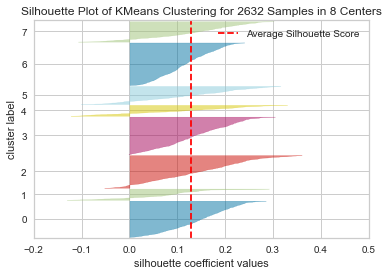

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 2632 Samples in 8 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [727]:
km = KMeans(n_clusters=8, init='k-means++', n_init=10, max_iter=100, random_state=42)

visualizer = SilhouetteVisualizer(km, colors='yellowbrick')
visualizer.fit(X_scaled)
visualizer.show()

In [714]:
kmeans_8 = KMeans(n_clusters=8, random_state=42)
kmeans_8.fit(X_2D)
clusters_8 = kmeans_8.predict(X_2D)

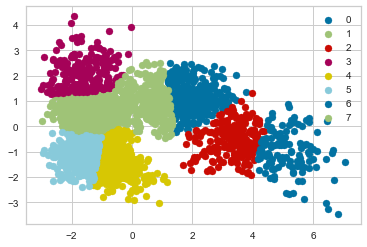

In [715]:
labels = np.unique(clusters_8)

for i in labels:
    plt.scatter(X_2D[clusters_8 == i , 0] , X_2D[clusters_8 == i , 1] , label = i)
plt.legend()
plt.show()

## Testing different clustering models to check if some fit the data better
### DBSCAN

In [580]:
model = DBSCAN(eps=0.75, min_samples=4)
# fit model and predict clusters
dbscan_results = model.fit_predict(X_scaled)

In [581]:
# retrieve unique clusters
clusters_2 = np.unique(dbscan_results)
clusters_2

array([-1,  0,  1,  2,  3,  4], dtype=int64)

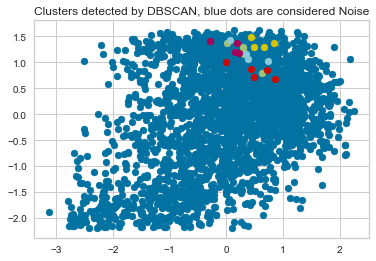

In [582]:
%matplotlib inline

#X_df['clusters'] = clusters

# create scatter plot for samples from each cluster
for cluster in clusters_2:
    # get row indexes for samples with this cluster
    row_ix = np.where(dbscan_results == cluster)
    
    #X_df[X_df['clusters'] == cluster]
    
    # create scatter of these samples
    plt.scatter(X_[row_ix, 0], X_[row_ix, 1])

# show the plot
plt.title("Clusters detected by DBSCAN, blue dots are considered Noise")
plt.show()

##### Finding the best K and epsilon

In [583]:
d = distance_matrix(X_scaled,X_scaled)
print(d)
print()

[[0.         3.3166226  3.57797104 ... 5.20649807 5.76966146 4.23889016]
 [3.3166226  0.         4.60691794 ... 6.34772212 7.50476135 5.99052458]
 [3.57797104 4.60691794 0.         ... 4.89566373 6.2774208  4.51546511]
 ...
 [5.20649807 6.34772212 4.89566373 ... 0.         4.35602346 3.54538435]
 [5.76966146 7.50476135 6.2774208  ... 4.35602346 0.         3.74063589]
 [4.23889016 5.99052458 4.51546511 ... 3.54538435 3.74063589 0.        ]]



In [584]:
# We need to sort this matrix by row and to ignore the first element as it is the distance to every point to itself (ie. 0)
d2 = np.sort(d)[:,1:]
print(d2)

[[ 1.13291352  1.24652415  1.2528884  ... 11.06135951 11.67820574
  12.98870927]
 [ 0.          1.47526582  1.51840443 ... 12.59662164 13.06699326
  13.83568911]
 [ 1.50823813  1.72549457  1.87525797 ... 11.27513251 11.73729773
  12.37350796]
 ...
 [ 1.23442295  1.26447908  1.62252768 ... 10.51745251 10.90749358
  11.63016854]
 [ 0.98927339  1.59879381  1.7813147  ... 10.61726595 10.6529394
  11.12106652]
 [ 1.47609942  1.62157663  1.74853826 ... 10.97994276 11.72555634
  12.00421932]]


In [585]:
# We select the k-th column, for example k = 3 (ie. the distance from each point to it's 4-th nearest neighbourgh.
f = d2[:,3]
print(f)

[1.27476737 1.57507488 1.89909403 ... 1.69532321 1.81108563 1.87754739]


In [586]:
# We sort the 3-th distances in descending order.
f_final = np.sort(f)[::-1]
print()
print(f_final)


[5.80933152 5.11398637 4.66023888 ... 0.77834084 0.75469974 0.72559936]


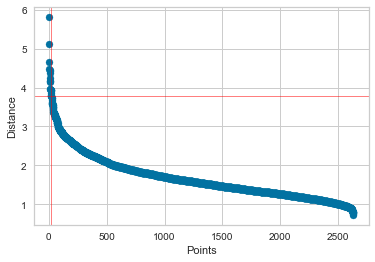

In [587]:
# We plot those distances.
plt.scatter(range(1,len(f_final)+1), f_final)
plt.xlabel("Points")
plt.ylabel("Distance")
# Current selected settings for DBSCAN
xnew = 20
ynew = f_final[20]
plt.axvline(xnew, color='red', linewidth=0.5)
plt.axhline(ynew, color='red', linewidth=0.5)
plt.grid(b=True)
plt.show()

In [592]:
f_final[4]

4.454170466105494

In [589]:
f_final[2]

4.6602388845327045

In [593]:
model_2 = DBSCAN(eps=f_final[4], min_samples=4)
# fit model and predict clusters
dbscan_results_2 = model_2.fit_predict(X_scaled)

In [594]:
pd.Series(dbscan_results_2).value_counts()

0    2617
1      15
dtype: int64

In [595]:
# retrieve unique clusters
clusters_2bis = np.unique(dbscan_results_2)
clusters_2bis

array([0, 1], dtype=int64)

In [596]:
row = np.where(dbscan_results_2 == 1)
row

(array([  53,   95,  655,  666, 2054, 2160, 2197, 2301, 2314, 2368, 2372,
        2375, 2404, 2597, 2622], dtype=int64),)

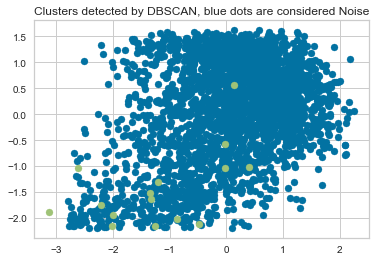

In [597]:
# create scatter plot for samples from each cluster
for cluster in clusters_2bis:
    row_ix2 = np.where(dbscan_results_2 == cluster)
    plt.scatter(X_[row_ix2, 0], X_[row_ix2, 1])

# show the plot
plt.title("Clusters detected by DBSCAN, blue dots are considered Noise")
plt.show()

Horrible results with DBSCAN.

### Gaussian Mixture

In [598]:
gmm = GaussianMixture(n_components=2, covariance_type='spherical')
gmm.fit(X_scaled)

labels = gmm.predict(X_scaled)

##### Plotting the predictions

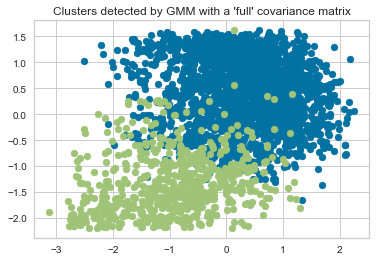

In [599]:
# create scatter plot for samples from each cluster
for cluster in np.unique(labels):
    # get row indexes for samples with this cluster
    row_ix = np.where(labels == cluster)
    # create scatter of these samples
    plt.scatter(X_[row_ix, 0], X_[row_ix, 1])

# show the plot
plt.title("Clusters detected by GMM with a 'full' covariance matrix")
plt.show()

### Spectral clustering

In [600]:
s_clustering = SpectralClustering(n_clusters=5, assign_labels='discretize', random_state=42).fit(X_scaled)
labels_sc = s_clustering.labels_

In [601]:
pd.Series(labels_sc).value_counts()

0    2395
3     218
2      10
4       5
1       4
dtype: int64

##### Plotting the predictions

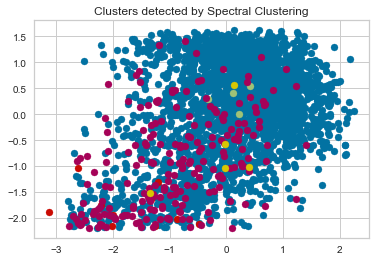

In [602]:
# create scatter plot for samples from each cluster
for cluster in np.unique(labels_sc):
    # get row indexes for samples with this cluster
    row_ix = np.where(labels_sc == cluster)
    # create scatter of these samples
    plt.scatter(X_[row_ix, 0], X_[row_ix, 1])

# show the plot
plt.title("Clusters detected by Spectral Clustering")
plt.show()

### Affinity propagation

In [603]:
AP_clustering = AffinityPropagation(random_state=42).fit(X_scaled)
AP_labels = AP_clustering.labels_

##### Plotting the predictions

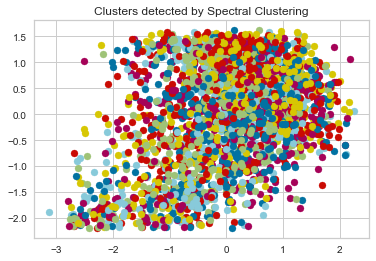

In [604]:
# create scatter plot for samples from each cluster
for cluster in np.unique(AP_labels):
    # get row indexes for samples with this cluster
    row_ix = np.where(AP_labels == cluster)
    # create scatter of these samples
    plt.scatter(X_[row_ix, 0], X_[row_ix, 1])

# show the plot
plt.title("Clusters detected by Spectral Clustering")
plt.show()

**Conclusion** 

For now KMeans yields the best results.

## Building the song recommendation

##### Model with selected number of clusters

In [659]:
# fitting and predicting
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(X_scaled)
clusters = kmeans.predict(X_scaled)
print(pd.Series(clusters).unique())

# creating a result dataframe
results_K = pd.DataFrame(song_pool)
results_K["cluster"] = clusters
results_K.head()

[1 2 3 0]


,track_id,track_name,track_popularity,artist_name,artist_popularity,genres,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,cluster
0,0gplL1WMoJ6iYaPgMCL0gX,Easy On Me,87,Adele,84,"[british soul, pop, pop soul, uk pop]",0.604,0.366,5,-7.519,1,0.0282,0.5780,0.000000,0.133,0.130,141.981,224695,4,1
1,6I3mqTwhRpn34SLVafSH7G,Ghost,89,Justin Bieber,90,"[canadian pop, pop]",0.601,0.741,2,-5.569,1,0.0478,0.1850,0.000029,0.415,0.441,153.960,153190,4,2
2,0lx2cLdOt3piJbcaXIV74f,willow,77,Taylor Swift,92,[pop],0.392,0.574,7,-9.195,1,0.1700,0.8330,0.001790,0.145,0.529,81.112,214707,4,1
3,0oWraSo5ASJ0h1BEagTyEw,Hold My Hand,82,Lady Gaga,83,"[art pop, dance pop, pop]",0.519,0.617,7,-4.287,1,0.0313,0.0387,0.000000,0.401,0.222,147.708,225300,3,2
4,78nplE9X2ZGvQh3TKgvldE,Rewrite The Stars (with James Arthur & Anne-Ma...,66,James Arthur,77,"[pop, talent show, uk pop]",0.670,0.743,10,-4.993,1,0.0393,0.2370,0.000000,0.465,0.571,125.944,218293,4,2


In [678]:
def song_rec():
    
    # ask user for input
    song_artist = (input('Pick a song: ') + (' - ') + input('by artist :')).lower().title()
    print()
    print('For the fans of: ', song_artist)
    print()
    
    # getting the song data
    results = sp.search(q=f'track:{song_artist}', limit=1)
    track_id = results['tracks']['items'][0]['id']
    
    
    #getting the popular song data (included in the function because it fluctuates)
    r = requests.get('http://www.popvortex.com/music/charts/top-100-songs.php')
    html = r.content
    soup = BeautifulSoup(html, 'html.parser')
    
    song_name = []
    artist = []

    # Creating two lists for the artists and songs
    num_iter = len(soup.select("cite.title"))
    num_iter_2 = len(soup.select("em.artist"))

    for i in range(num_iter):
        song_name.append(soup.select("cite.title")[i].get_text())

    for i in range(num_iter_2):
        artist.append(soup.select("em.artist")[i].get_text())

    # each list becomes a column
    billboard = pd.DataFrame({"song":song_name,
                           "artist":artist,
                          })
    
    # creating a column with both the song and the artist
    billboard['song_artist'] = billboard['song'] + ' - ' + billboard['artist']
    
    
    print('Picked for you: ')
    
    
    # checking if the song is a popular song
    if billboard['song_artist'].str.contains(song_artist).sum() > 0:
        #print('\n Recommended popular song: ')
        rec = str(billboard['song_artist'].sample().unique()[0])
        print(rec)
    
    
    # if the song is not a popular song we recommend a similar song
    else:
        # getting the song features with the track id
        song_audio = sp.audio_features(track_id)
        
        # create dataframe
        df = pd.DataFrame(song_audio)
        col_names = list(audio_features.columns)
        features = df[col_names]
        
        # scale the features
        scaler = StandardScaler()
        scaler.fit_transform(X_scaled)
        scaled_features = scaler.transform(features)
        
        # predict cluster
        cluster = kmeans.predict(scaled_features)
        
        # filter dataset to predicted cluster
        filtered_df = results_K[results_K['cluster'] == cluster[0]][audio_features.columns]
        
        # get closest song from filtered dataset
        closest, _ = pairwise_distances_argmin_min(scaled_features, filtered_df) 
        rec = ' - '.join([results_K.loc[closest]['track_name'].values[0], results_K.loc[closest]['artist_name'].values[0]])
        print(rec)
    
    return ()


In [728]:
test = song_rec()

Pick a song: willow
by artist :taylor swift

For the fans of:  Willow - Taylor Swift

Picked for you: 
Underneath the Cottonwoods - Justin Sconza


###### Checking that the song is not in the popular songs

In [707]:
billboard[billboard['artist'] == 'Taylor Swift']

,song,artist


##### Testing with a song that is in the billboard 100 dataframe

In [704]:
test2 = song_rec()

Pick a song: as it was
by artist :harry styles

For the fans of:  As It Was - Harry Styles

Picked for you: 
Damn Strait - Scotty McCreery


In [730]:
billboard[billboard['artist'] == 'Harry Styles']

,song,artist
4,As It Was,Harry Styles
62,Late Night Talking,Harry Styles
63,Music For a Sushi Restaurant,Harry Styles
91,Watermelon Sugar,Harry Styles


In [731]:
billboard[billboard['artist'] == 'Scotty McCreery']

,song,artist
64,Damn Strait,Scotty McCreery


##### Troubleshooting

In [695]:
res = sp.search(q='Fold - Portair', limit=1)
t_id = res['tracks']['items'][0]['id']

In [696]:
t_id

'75roy5mcsPJKiyXOWlAJDh'

In [697]:
res

{'tracks': {'href': 'https://api.spotify.com/v1/search?query=Fold+-+Portair&type=track&offset=0&limit=1',
  'items': [{'album': {'album_type': 'single',
     'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/5eNDu0xRakAeO0Za8pRIuG'},
       'href': 'https://api.spotify.com/v1/artists/5eNDu0xRakAeO0Za8pRIuG',
       'id': '5eNDu0xRakAeO0Za8pRIuG',
       'name': 'Portair',
       'type': 'artist',
       'uri': 'spotify:artist:5eNDu0xRakAeO0Za8pRIuG'}],
     'available_markets': ['AD',
      'AE',
      'AG',
      'AL',
      'AM',
      'AO',
      'AR',
      'AT',
      'AU',
      'AZ',
      'BA',
      'BB',
      'BD',
      'BE',
      'BF',
      'BG',
      'BH',
      'BI',
      'BJ',
      'BN',
      'BO',
      'BR',
      'BS',
      'BT',
      'BW',
      'BY',
      'BZ',
      'CA',
      'CD',
      'CG',
      'CH',
      'CI',
      'CL',
      'CM',
      'CO',
      'CR',
      'CV',
      'CW',
      'CY',
      'CZ',
      'DE',
     

In [698]:
res = sp.search(q='Lying To Myself - Portair', limit=1)
t_id = res['tracks']['items'][0]['id']
t_id

'58ajhiH7UPRfC9upB92gXD'

In [699]:
res

{'tracks': {'href': 'https://api.spotify.com/v1/search?query=Lying+To+Myself+-+Portair&type=track&offset=0&limit=1',
  'items': [{'album': {'album_type': 'single',
     'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/5eNDu0xRakAeO0Za8pRIuG'},
       'href': 'https://api.spotify.com/v1/artists/5eNDu0xRakAeO0Za8pRIuG',
       'id': '5eNDu0xRakAeO0Za8pRIuG',
       'name': 'Portair',
       'type': 'artist',
       'uri': 'spotify:artist:5eNDu0xRakAeO0Za8pRIuG'}],
     'available_markets': ['AD',
      'AE',
      'AG',
      'AL',
      'AM',
      'AO',
      'AR',
      'AT',
      'AU',
      'AZ',
      'BA',
      'BB',
      'BD',
      'BE',
      'BF',
      'BG',
      'BH',
      'BI',
      'BJ',
      'BN',
      'BO',
      'BR',
      'BS',
      'BT',
      'BW',
      'BY',
      'BZ',
      'CA',
      'CD',
      'CG',
      'CH',
      'CI',
      'CL',
      'CM',
      'CO',
      'CR',
      'CV',
      'CW',
      'CY',
      'CZ',
      